Code to visualize numpy output from sourmash compare
label.txt files were saved as output from sourmash compute.

In [ ]:
# sourmash compare -o yeast_syrah_L2 ./*sig  # completed in terminal

*NB* output was saved to csv file from python using the command:

In [ ]:
# Python:
# import numpy
          # from sourmash_lib import fig
          # import pylab
          # D, labels = fig.load_matrix_and_labels('yeast_syrah_L2')
          # D = (D + D.T) / 2.0
          # numpy.savetxt("L2_numpy.csv", D, delimiter=",")

In [ ]:
# Or use:
       # for i in glob.glob('compared*'):
          #   if i.endswith("labels.txt") or i.endswith(".csv"):
          #   continue
          # print i
          # D, labels = fig.load_matrix_and_labels(i)
          # D = (D + D.T) / 2.0
          # numpy.savetxt("{}.csv".format(i), D, delimiter=",")

After files are created, create a function to import data in to R in the proper format

In [1]:
# Function to import numpy txt file
    numpy_in<-function(row) {
            csv_filename = row[1]
            labels_filename = row[2]
       # read in numpy matrix
            numpy_mat<-read.csv(csv_filename, header= F)
        # import labels
            numpy_labs<-read.delim(labels_filename, header = F)
        # add labels to matrix 
            numpy_obj<-cbind(numpy_labs, numpy_mat)
            numpy_obj <- data.frame(numpy_obj[,-1], row.names=numpy_obj[,1])
            numpy_labs<-as.vector(numpy_labs[,1])
            colnames(numpy_obj) <- numpy_labs
            return(numpy_obj)
        }

The code below relies on a regular expression, meaning it will not work properly unless the files are named according to the same naming scheme I used. 

In [2]:
 # Process files for downstream application
                # determine k sizes used for sourmash compute and compare (regex that acts on file name)
                determine_k_size<-function(input_csv_file){
                  library(stringr)
                  # regex for k size:
                  k_size_regex<-"\\.[0-9]{1,2}\\."
                  k_extraction_one<-str_extract(input_csv_file, k_size_regex)
                  k_size_regex2<-"[0-9]{1,2}"
                  k_size<-str_extract(k_extraction_one, k_size_regex2) 
                }
                
                # determine scale sizes used for sourmash compute (regex that acts on file name)
                determine_scale_size<-function(input_csv_file){
                  library(stringr)
                  # regex for --scale parameter:
                  scale_size_regex<-"\\.[0-9]{3,6}\\."
                  scale_extraction_one<-str_extract(input_csv_file, scale_size_regex)
                  scale_size_regex2<-"[0-9]{3,6}"
                  scale_size_regex2<-str_extract(scale_extraction_one, scale_size_regex2)
                }

In order to compare how similar technical replicates were, I calculated their "similarity" and "standard error". Similarity was calculated by taking the sum of all proportions in the upper diagonal of the `sourmash compare` output matrix. The diagonal (or, *SNF2 BR13 T1* vs *SNF2 BR13 T1*) was included in this sum. Then the average of these proportions was taken.

To calculate standard error, the standard deviation of the upper diagonal of the `sourmash compare` was taken, again with the diagonal included, and then this was divided by the square root of the number of proportions considered. 

In [3]:
# Functions to enable standard curve plots
          
          similarity<-function(sourmash_compare_matrix){
              sum(sourmash_compare_matrix[upper.tri(sourmash_compare_matrix, diag=T)])/
              (length(sourmash_compare_matrix[upper.tri(sourmash_compare_matrix, diag=T)]))
          }
         
          standard_error<-function(sourmash_compare_matrix) {
          scm = sourmash_compare_matrix[upper.tri(sourmash_compare_matrix, diag = TRUE)]
          sd(scm)/sqrt(length(scm))
          }

Read in *SNF2 BR13* data. `sourmash compare` numpy was output as a csv file, and read in to R. These were then passed through the functions written above, and the output was written to a dataframe.  

In [4]:
 # Apply to snf2 br13 data
    # Read in files from SNF2 BR 13 full run
        setwd("/Users/taylorreiter/Desktop/DIB/Yeast_(Schurch)/yeast_original_fastq/SNF2_BR13/sourmash_compare_output/")
    # Read in csv files of comparisons
    # Read  csv file names
        csv_files<-list.files(".","csv$")
        length(csv_files)
    # Read label file names (txt)
        csv_labels<-list.files(".", "txt$")
        length(csv_labels)
          
    # bind vectors for input into numpy_in function
        snf2_br13_numpy_in<-cbind(csv_files, csv_labels)
          
    #Import files
        all_snf2_br13<-apply(snf2_br13_numpy_in, 1, numpy_in)  

    # Compute necessary things for files
        similarity_snf2_br13<-sapply(all_snf2_br13, similarity)
        standard_err_snf2_br13<-sapply(all_snf2_br13, standard_error)
        k_size_snf2_br13<-sapply(csv_files, determine_k_size)
        scale_size_snf2_br13<-sapply(csv_files, determine_scale_size)
          
    # Bind numeric columns together 
        snf2_br13_sim_stderr<-cbind(similarity_snf2_br13, standard_err_snf2_br13, k_size_snf2_br13, scale_size_snf2_br13)

    # convert from factor/character to numeric 
        snf2_br13_sim_stderr <- data.frame(apply(snf2_br13_sim_stderr, 2, function(x) as.numeric(as.character(x))))
    # bind csv_file_name (character) column 
        snf2_br13_sim_stderr <-cbind(csv_files, snf2_br13_sim_stderr)
    head(snf2_br13_sim_stderr)

[1] 81

[1] 81

Warning message:
“package ‘stringr’ was built under R version 3.2.5”

csv_files,similarity_snf2_br13,standard_err_snf2_br13,k_size_snf2_br13,scale_size_snf2_br13
compared.12.10000.csv,0.9009221,0.011058256,12,10000
compared.12.160000.csv,0.8893193,0.013350478,12,160000
compared.12.20000.csv,0.9137944,0.009688721,12,20000
compared.12.240000.csv,0.8990809,0.012400708,12,240000
compared.12.40000.csv,0.8534887,0.016663676,12,40000
compared.12.480000.csv,0.8945089,0.015468103,12,480000


Plot the output. Each plot represents a *k-mer* value, and the `--scaled` value (i.e., for `--scaled` 10000, one *k-mer* is sampled from every 10000 *k-mers*) is plotted on the x axis. On the y axis, average proportion of similarity is plotted. In this data set, a scaled value of 40000 and a *k-mer* size of 27 seems to perfom best.  

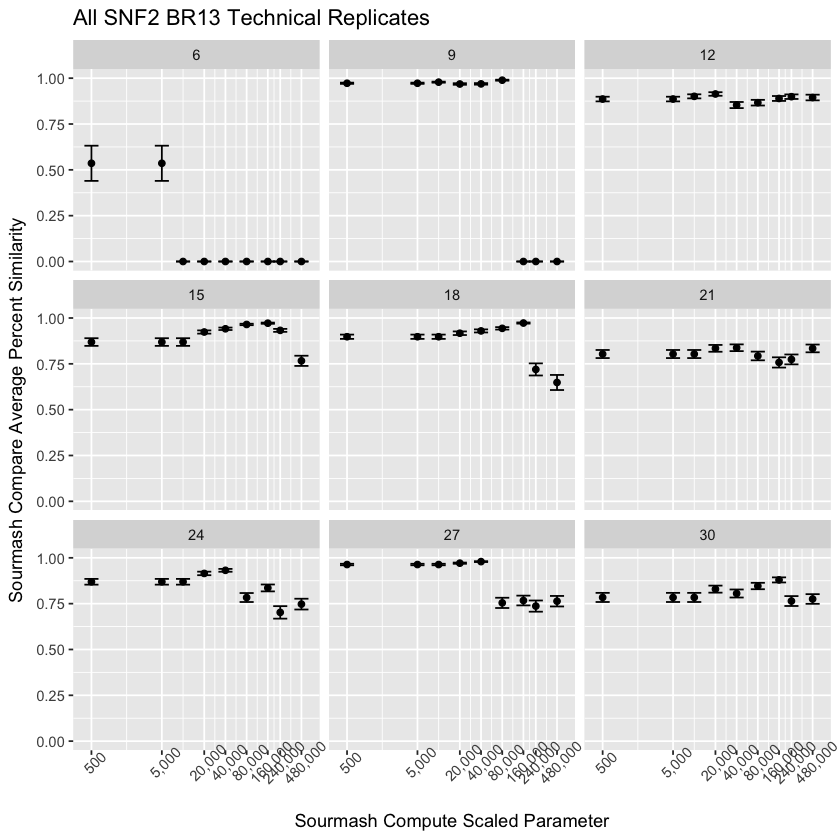

In [35]:
# Plot the data 
library(ggplot2)
library(scales)

snf2_br13_sim_stderr_plot<-ggplot(snf2_br13_sim_stderr, aes(x = scale_size_snf2_br13, y = similarity_snf2_br13, ymin=similarity_snf2_br13-standard_err_snf2_br13, ymax=similarity_snf2_br13+standard_err_snf2_br13)) + 
    geom_point() + ggtitle("All SNF2 BR13 Technical Replicates") + ylim(0,1) + theme(axis.text.x = element_text(angle=45)) + 
    ylab("Sourmash Compare Average Percent Similarity") + xlab("Sourmash Compute Scaled Parameter") + 
    scale_x_log10(breaks=c(500, 5000, 20000, 40000, 80000, 160000, 240000, 480000), labels = comma) +  
    geom_errorbar(width=0.2) + facet_wrap(~ k_size_snf2_br13)
snf2_br13_sim_stderr_plot

Next, data from *SNF2 BR13*, *SNF2 BR48*, *WT BR21* and *WT BR34* were passed through `sourmash compute`. Because *k-mer* sizes 18 and 27 performed well, these were used. By recommendation of Titus (I think...), *k-mer* size 36 was added as well. Scaled values 20000, 40000, 60000, and 80000 were used. `sourmash compare` was then used to calculate similarity between the output signatures. Again, the numpy object was output as a csv and read in to R, where it was processed the same as above.

In [39]:
 # apply to all
    # Read in files from SNF2 BR 13 full run
        setwd("/Users/taylorreiter/Desktop/DIB/Yeast_(Schurch)/yeast_original_fastq/all_compute_compare/")
    # Read in csv files of comparisons
    # Read  csv file names
        csv_files<-list.files(".","csv$")
        length(csv_files)
    # Read label file names (txt)
        csv_labels<-list.files(".", "txt$")
        length(csv_labels)
        csv_labels<-csv_labels[1:12]
        length(csv_labels)
          
    # bind vectors for input into numpy_in function
        all_numpy_in<-cbind(csv_files, csv_labels)
          
    #Import files
        all_in<-apply(all_numpy_in, 1, numpy_in)  
          
        similarity_all_in<-sapply(all_in, similarity)
        standard_err_all_in<-sapply(all_in, standard_error)
        k_size_all_in<-sapply(csv_files, determine_k_size)
        scale_size_all_in<-sapply(csv_files, determine_scale_size)
          
    # Bind numeric columns together 
        all_in_sim_stderr<-cbind(similarity_all_in, standard_err_all_in, k_size_all_in, scale_size_all_in)
          
    # convert from factor/character to numeric 
        all_in_sim_stderr <- data.frame(apply(all_in_sim_stderr, 2, function(x) as.numeric(as.character(x))))
    # bind csv_file_name (character) column 
        all_in_sim_stderr <-cbind(csv_files, all_in_sim_stderr)
          
    head(all_in_sim_stderr)

[1] 12

[1] 13

[1] 12

csv_files,similarity_all_in,standard_err_all_in,k_size_all_in,scale_size_all_in
compared.18.20000.csv,0.5836699,0.012035264,18,20000
compared.18.40000.csv,0.7196254,0.007688064,18,40000
compared.18.60000.csv,0.7298319,0.007678244,18,60000
compared.18.80000.csv,0.7624390,0.007131274,18,80000
compared.27.20000.csv,0.5465607,0.014447969,27,20000
compared.27.40000.csv,0.5414501,0.014973960,27,40000


For a sanity check, a similar plot was made as above. Similarity between samples drops markedly, which would be expected because *WT* is being compared against *SNF2*.

Warning message:
“Removed 12 rows containing missing values (geom_point).”

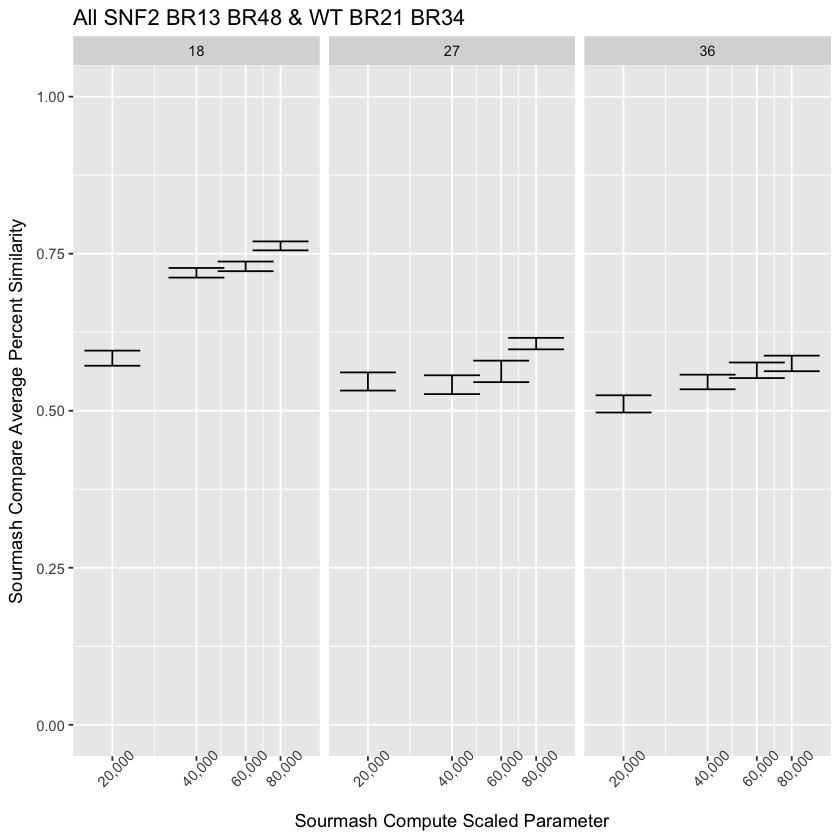

In [40]:
# Plot all data, faceted on k size
library(ggplot2)
library(scales)
          
all_in_sim_stderr_plot<-ggplot(all_in_sim_stderr, aes(x = scale_size_all_in, y = k_size_all_in, ymin=similarity_all_in-standard_err_all_in, ymax=similarity_all_in+standard_err_all_in)) + 
    geom_point() + ggtitle("All SNF2 BR13 BR48 & WT BR21 BR34") + ylim(0,1) + theme(axis.text.x = element_text(angle=45))  + 
    ylab("Sourmash Compare Average Percent Similarity") + xlab("Sourmash Compute Scaled Parameter")  + 
    scale_x_log10(breaks=c(20000, 40000, 60000, 80000), labels = comma) +  
    geom_errorbar(width=0.2) + facet_wrap(~ k_size_all_in)

all_in_sim_stderr_plot


Then, hierarchical clustering was performed on the samples in order to discern whether samples clustered by treatment, by batch effect, or willy nilly. Hierarchical clustering was performed with spearman method, and average distance was used for clustering. Labels were changed so that only the accession number was shown.

In [42]:
# Heirarchical clustering analysis
    # calculate correlation
    cor_all<-lapply(all_in, function(x) {cor(x, method="spearman")})
    # cor_all_spearman <- cor(all_in[[1]], method="spearman")
          # Method options: pearson, kendall, spearman. Default pearson.
    # calculate hierarchical cluster
    norm_cor_all<-lapply(cor_all, function(x) {(1-x)})
    dist_cor_all<-lapply(norm_cor_all, function(x) {dist(x)})
    hc_all<-lapply(dist_cor_all, function(x) {hclust(x, method="average")})
    # hc_all<-hclust(dist(1-cor_all_spearman), method="average")
    # Method: complete, average, single, mcquitty, median, centroid, ward.D, ward.D2
    # change labels to only ERR number
              for(i in 1:length(hc_all)) {
              truncate_label_regex<-"(ERR[0-9]{4,8})"
              library(stringr)
              labels_hc<-str_extract(hc_all[[i]]$labels, truncate_label_regex)
              print(labels_hc)
              hc_all[[i]]$labels<-labels_hc}


 [1] "ERR458584" "ERR458585" "ERR458586" "ERR458587" "ERR458588" "ERR458589"
 [7] "ERR458590" "ERR458829" "ERR458830" "ERR458831" "ERR458832" "ERR458833"
[13] "ERR458834" "ERR458835" "ERR459011" "ERR459012" "ERR459013" "ERR459014"
[19] "ERR459015" "ERR459016" "ERR459017" "ERR459102" "ERR459103" "ERR459104"
[25] "ERR459105" "ERR459106" "ERR459107" "ERR459108"
 [1] "ERR458584" "ERR458585" "ERR458586" "ERR458587" "ERR458588" "ERR458589"
 [7] "ERR458590" "ERR458829" "ERR458830" "ERR458831" "ERR458832" "ERR458833"
[13] "ERR458834" "ERR458835" "ERR459011" "ERR459012" "ERR459013" "ERR459014"
[19] "ERR459015" "ERR459016" "ERR459017" "ERR459102" "ERR459103" "ERR459104"
[25] "ERR459105" "ERR459106" "ERR459107" "ERR459108"
 [1] "ERR458584" "ERR458585" "ERR458586" "ERR458587" "ERR458588" "ERR458589"
 [7] "ERR458590" "ERR458829" "ERR458830" "ERR458831" "ERR458832" "ERR458833"
[13] "ERR458834" "ERR458835" "ERR459011" "ERR459012" "ERR459013" "ERR459014"
[19] "ERR459015" "ERR459016" "ERR459017" "ERR45

The code below uses a regular expression to select colors for the labels on the dendograms.

In [44]:
# pick a pretty color for SNF2 and for WT
        color_by_type<-function(names) {
              library(stringr)
              # detect if WT is present in the name
              magenta <-"(ERR458[0-9]{1,6})"
              is_MUT<-str_detect(names, magenta)
              # detect if SNF2 is present in the name
              cyan <-"(ERR459[0-9]{1,6})"
              is_WT<-str_detect(names, cyan)
              # if WT is detected, black, else blue
              ifelse(is_WT==F, "magenta", "cyan")
            }

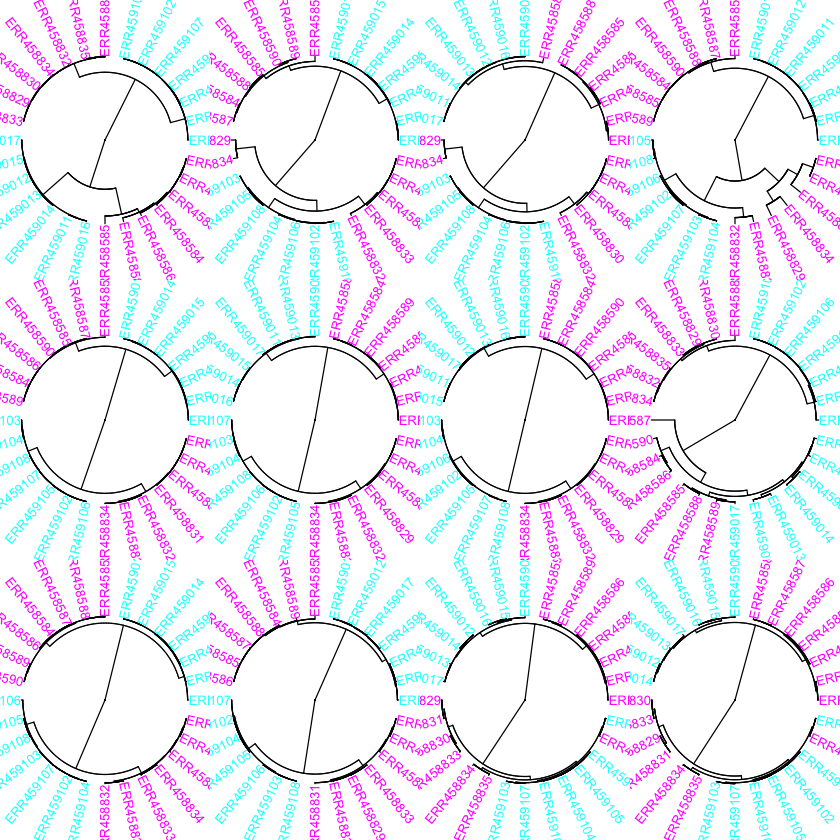

In [48]:
library(ape)
par(mfrow=c(3,4)) 

# Make the plot!
    plots_all<-sapply(hc_all, function(x) {plot.phylo(as.phylo(x), type="fan", no.margin=TRUE, font = 1, cex = 1, tip.color = color_by_type(x$labels))})

And all the junk that it took us to get to the code above

In [ ]:
# Old trials before code was cleaned
    # # import lane 2 signature (test the function)
    # L2_sourmash_comp<-numpy_in("/Users/taylorreiter/Desktop/Titus_Brown/yeast_syrah/L2/L2_numpy.csv", "/Users/taylorreiter/Desktop/Titus_Brown/yeast_syrah/L2/yeast_syrah_L2.labels.txt")
    # # check file integrity
    # head(L2_sourmash_comp)
    
    # # subset to remove the file names that are not comparison files
    # csv_files<-csv_files[1:90]
    # # Remove k = 1000--unidentified error, being ignored right now
    # library(stringr)
    # regex_eliminate_k1000<-"^((?!.1000.).)*$"  # mimicing 'does not contain' in regex
    # csv_files_no_k1000<-str_extract(csv_files, regex_eliminate_k1000)
    # csv_files_no_k1000<-csv_files_no_k1000[!is.na(csv_files_no_k1000)]
    # csv_labels_no_k1000<-str_extract(csv_labels, regex_eliminate_k1000)
    # csv_labels_no_k1000<-csv_labels_no_k1000[!is.na(csv_labels_no_k1000)]
  ---------------------------  
# # plot all data, faceted on k size
          # plot_all<-function(plot_data){
          #       library(ggplot2)
          #       environment = environment()
          #       plot<-ggplot(plot_data, aes_string(x = colnames(plot_data)[5], y = colnames(plot_data)[2], ymin=(plot_data)[2]-(plot_data)[3], (plot_data)[2]+(plot_data)[3])) + 
          #       geom_point() + ggtitle("All") + ylim(0,1) + 
          #       theme(axis.text.x = element_text(angle=45))  + 
          #       ylab("Average Percent Similarity") + xlab("Sourmash Scaled Parameter")  + 
          #       scale_x_log10(breaks=colnames(plot_data)[5], labels = comma) +  
          #       geom_errorbar(width=0.2) 
          #       
          #       #plot + facet_wrap(~ names(plot_data)[4])
          # }
          # plot<-plot_all(snf2_br13_sim_stderr)
------------------------------------------------------------------------   
    ## Plot 
      ## Heirarchical clustering analysis
      ## calculate correlation
    #   cor_L2 <- cor(L2_sourmash_comp, method="spearman")
    ##  calculate hierarchical cluster
    # hc_L2<-hclust(dist(1-cor_L2), method="average")
    # 
    ## function for colors of tips
    #  color_by_type<-function(names) {
    #   library(stringr)
    ## detect if WT is present in the name
    #   black <-"(ERR[0-9]{4,8})(\\.)(WT)(\\.)(BR[0-9]{1,2})(\\.)(L[0-9]{1})"
    #   is_WT<-str_detect(names, black)
    ## detect if SNF2 is present in the name
    #   blue <-"(ERR[0-9]{4,8})(\\.)(SNF2)(\\.)(BR[0-9]{1,2})(\\.)(L[0-9]{1})"
    #   is_MUT<-str_detect(names, blue)
    ## if WT is detected, black, else blue
    #   ifelse(is_WT==T, "black", "blue")
    # }
    # 
    
# function for colors of tips (works best for Syrah data)
   # color_by_type<-function(names) {
    #      library(stringr)
          # detect if WT is present in the name
     #     black <-"(ERR[0-9]{4,8})(\\.)(WT)(\\.)(BR[0-9]{1,2})(\\.)(L[0-9]{1})"
      #    is_WT<-str_detect(names, black)
          # detect if SNF2 is present in the name
       #   blue <-"(ERR[0-9]{4,8})(\\.)(SNF2)(\\.)(BR[0-9]{1,2})(\\.)(L[0-9]{1})"
        #  is_MUT<-str_detect(names, blue)
          # if WT is detected, black, else blue
         # ifelse(is_WT==T, "black", "blue")
        #}
    ## plot
    # library(ape) #package for phylo.plot
    # plot.phylo(as.phylo(hc_L2), type="fan", no.margin=TRUE, font = 1, cex = 1, tip.color = color_by_type(hc_L2$labels))

   
    
    # Plot 
    # Heirarchical clustering analysis
    # calculate correlation
    cor_all <- cor(all_in[[1]], method="spearman")
    ## calculate hierarchical cluster
    hc_all<-hclust(dist(1-cor_all), method="average")

    # plot
    library(ape) #package for phylo.plot
    plot.phylo(as.phylo(hc_all), type="fan", no.margin=TRUE, font = 1, cex = 1)